In [1]:
# here we define a function that we can call to execute our simulation under
# a variety of different alternative scenarios
import scipy as sp
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd
import shap
%config InlineBackend.figure_format = 'retina'
def run_credit_experiment(N, job_history_sex_impact=0, reported_income_sex_impact=0, income_sex_impact=0,
                          late_payments_sex_impact=0, default_rate_sex_impact=0,
                          include_brandx_purchase_score=False, include_sex=False):
    np.random.seed(0)
    sex = np.random.randint(0, 2, N) == 1 # randomly half men and half women

    # four hypothetical causal factors influence customer quality
    # they are all scaled to the same units between 0-1
    income_stability = np.random.rand(N)
    income_amount = np.random.rand(N)
    if income_sex_impact > 0:
        income_amount -= income_sex_impact/90000 * sex * np.random.rand(N)
        income_amount -= income_amount.min()
        income_amount /= income_amount.max()
    spending_restraint = np.random.rand(N)
    consistency = np.random.rand(N)

    # intuitively this product says that high customer quality comes from simultaneously
    # being strong in all factors
    customer_quality = income_stability * income_amount * spending_restraint * consistency

    # job history is a random function of the underlying income stability feature
    job_history = np.maximum(
        10 * income_stability + 2 * np.random.rand(N) - job_history_sex_impact * sex * np.random.rand(N)
    , 0)

    # reported income is a random function of the underlying income amount feature
    reported_income =  np.maximum(
        10000 + 90000*income_amount + np.random.randn(N) * 10000 - \
        reported_income_sex_impact * sex * np.random.rand(N)
    , 0)

    # credit inquiries is a random function of the underlying spending restraint and income amount features
    credit_inquiries = np.round(6 * np.maximum(-spending_restraint + income_amount, 0)) + \
                       np.round(np.random.rand(N) > 0.1)

    # credit inquiries is a random function of the underlying consistency and income stability features
    late_payments = np.maximum(
        np.round(3 * np.maximum((1-consistency) + 0.2 * (1-income_stability), 0)) + \
        np.round(np.random.rand(N) > 0.1) - np.round(late_payments_sex_impact * sex * np.random.rand(N))
    , 0)

    # bundle everything into a data frame and define the labels based on the default rate and customer quality
    X = pd.DataFrame({
        "Job history": job_history,
        "Reported income": reported_income,
        "Credit inquiries": credit_inquiries,
        "Late payments": late_payments
    })
    default_rate = 0.40 + sex * default_rate_sex_impact
    y = customer_quality < np.percentile(customer_quality, default_rate * 100)

    if include_brandx_purchase_score:
        brandx_purchase_score = sex + 0.8 * np.random.randn(N)
        X["Brand X purchase score"] = brandx_purchase_score

    if include_sex:
        X["Sex"] = sex + 0

    # build model
    import xgboost
    model = xgboost.XGBClassifier(max_depth=1, n_estimators=500, subsample=0.5, learning_rate=0.05)
    model.fit(X, y)

    # build explanation
    import shap
    explainer = shap.TreeExplainer(model, shap.sample(X, 100))
    shap_values = explainer.shap_values(X)

    return shap_values, sex, X, explainer.expected_value

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[21:54:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 98%|===================| 9828/10000 [00:19<00:00]        FixedFormatter should only be used together with FixedLocator


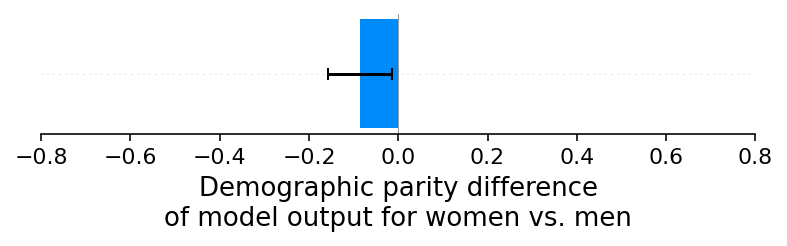

In [2]:
N = 10000
shap_values_A, sex_A, X_A, ev_A = run_credit_experiment(N)
model_outputs_A = ev_A + shap_values_A.sum(1)
glabel = "Demographic parity difference\nof model output for women vs. men"
xmin = -0.8
xmax = 0.8
shap.group_difference_plot(shap_values_A.sum(1), sex_A, xmin=xmin, xmax=xmax, xlabel=glabel)

In [7]:
ev_A

-0.8071553367163142

In [10]:
shap_values_A.sum(1)

array([-0.83746374,  1.98715054,  3.44526226, ...,  0.68594236,
       -0.76077857,  5.34634578])

In [13]:
np.random.randint(0, 2, N) 

array([0, 1, 1, ..., 1, 0, 1])

In [15]:
np.random.rand(N)

array([0.51908475, 0.63874166, 0.17990039, ..., 0.44612969, 0.98057075,
       0.35506848])